In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
plt.rcParams["figure.figsize"] = (15, 5)

**Import and prepare data**

Add extra columns

In [14]:
def prepare_data(coin):
    df = pd.read_csv(f'../../crypto_prices/coin_{coin}.csv', index_col=0).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df['dayofweek'] = df.Date.dt.dayofweek
    df['dayofmonth'] = df.Date.dt.day
    df['year_month'] = df.Date.dt.strftime("%Y-%m")
    df['avg_daily_price']= (df.High + df.Low) / 2
    return df

**Calculate profit**

Given the provided dataframe for a specific coin, and the configuration for the frequency of the DCA plan, calculate the profit in percantage accumulated over the specified time window.

In [15]:
def calculate_profit_dca(df, frequency, purchase_year_month = '2018-01',\
                        purchase_day_of_week = 0, purchase_day_of_month = [0]):
    purchase_usd = 10
    if frequency == 'monthly':
        freq_cond = (df.dayofmonth.isin(purchase_day_of_month))
    if frequency == 'weekly':
        freq_cond = (df.dayofweek == purchase_day_of_week)

    purchase = df[(df.year_month >= purchase_year_month) & freq_cond]
    purchased_amount = (purchase_usd/purchase.High).sum()
    investment_amount = purchase_usd * len(purchase)
    investment_value = df[-1:].High * purchased_amount
    return (investment_value / investment_amount)

The considered coins

In [16]:
coins = ['Bitcoin', 'Ethereum', 'Cardano', 'Polkadot']

Calculate profits for each day of the month, given a monthly DCA

In [17]:
day_of_month_profit = {'day': []}
for i in range(1,32):
    day_of_month_profit['day'].append(i)

for coin in coins:
    df = prepare_data(coin)
    day_of_month_profit[coin] = []
    print(f"Calculating profit for coin {coin}. Sample size {len(df)}...")
    for i in range(1,32):    
        day_of_month_profit[coin].append(calculate_profit_dca(df, 'monthly', purchase_day_of_month=[i]).iloc[0])

Calculating profit for coin Bitcoin. Sample size 2991...
Calculating profit for coin Ethereum. Sample size 2160...
Calculating profit for coin Cardano. Sample size 1374...
Calculating profit for coin Polkadot. Sample size 320...


In [18]:
profit_df = pd.DataFrame(day_of_month_profit).set_index('day')

Let's plot the values

<AxesSubplot:xlabel='day'>

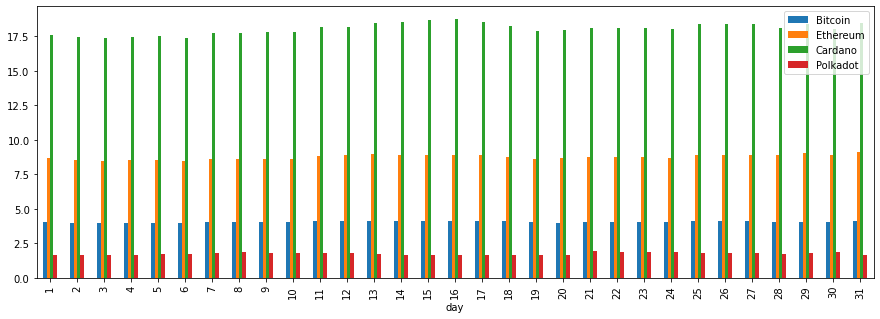

In [19]:
(profit_df).plot(kind='bar')

Given Cardano has a bigger scale, it is better to standardize the values

<AxesSubplot:xlabel='day', ylabel='z-score profit'>

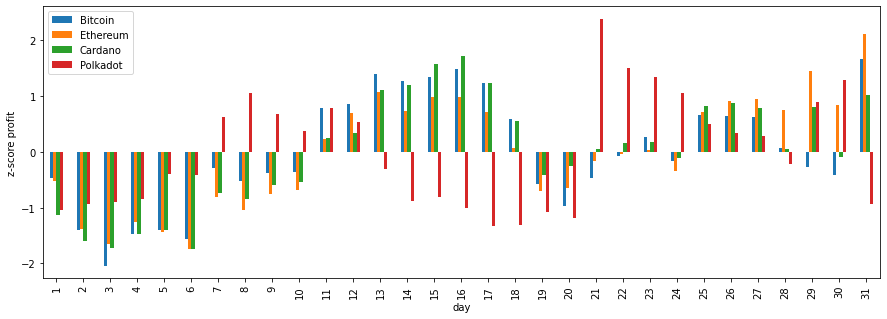

In [23]:
((profit_df - profit_df.mean())/profit_df.std()).plot(kind='bar', ylabel='z-score profit')

The plot is now standardized, but Polkadot presents wide swings. It is after all not correct to give all coins the same importance. Some coins have a smaller sample size, and therefore more variance. Furthermore, some coins represent a larger part of the portfolio and we are therefore interested in giving these priority. We exclude Polkadot because it has too few observations. We use the rank for the days and maximise the sum.
We give each coin a weight and find the maximum.

<AxesSubplot:xlabel='day', ylabel='z-score profit'>

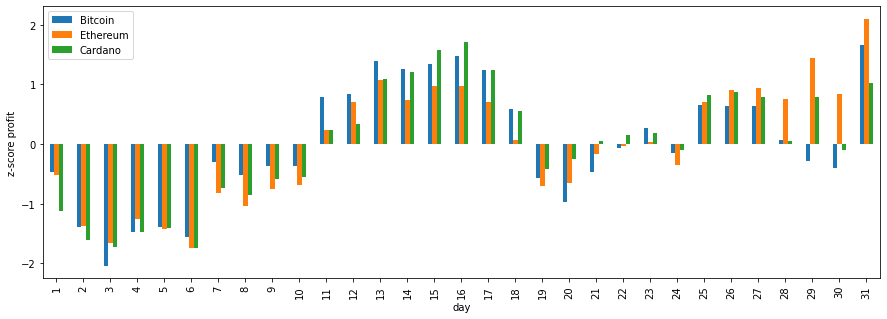

In [24]:
tdf = profit_df.drop(columns=['Polkadot'])
((tdf - tdf.mean())/tdf.std()).plot(kind='bar', ylabel='z-score profit')

In [21]:
profit_df.drop(columns=['Polkadot'])\
         .rank()\
         .transpose()\
         .apply(lambda x: (x.Bitcoin*50)+(x.Ethereum*40)+(x.Cardano*10)).idxmax()

31

The day that maximises the profits is 16